# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import re
import os
import cv2
import numpy as np
import json
from matplotlib import image
from matplotlib import pyplot as plt

# Preprocessing

In [2]:
# Label class mapping
classMap = list()
# Add 0-9
for i in range(10):
    classMap.append(str(i))
# Add A-Z
for i in range(65, 91):
    classMap.append(chr(i))
# Add a-z
for i in range(97, 123):
    classMap.append(chr(i))

In [3]:
class CharDataSet(Dataset):
    def __init__(self, dataPath, transform=None):
        self.dataPath = dataPath
        # Get all subdirectories in dataPath
        subdirNames = os.listdir(dataPath)
        subdirNames.sort()
        # Get the number of files in each subdirectory
        self.imgs = list()
        self.labels = list()
        for i in range(len(subdirNames)):
            subdirName = subdirNames[i]
            # Get the path of the subdirectory
            subdirPath = os.path.join(dataPath, subdirName)
            # Read all files in the subdirectory
            files = os.listdir(subdirPath)
            # Get file path
            for file in files:
                filePath = os.path.join(subdirPath, file)
                # Read image and label
                img = image.imread(filePath)
                # Transform image
                if transform is not None:
                    img = transform(img)
                # Get label
                label = i
                # Add to list
                self.imgs.append(img)
                self.labels.append(label)

    def __getitem__(self, index):
        # Check range
        if index < 0 or index >= len(self):
            raise IndexError("Index out of range")
        
        # Get image and label
        img = self.imgs[index]
        label = self.labels[index]

        return img, label

    def __len__(self):
        # Sum all the files in each subdirectory
        return len(self.imgs)

In [6]:
# Image transform
class ImageTransform():
    def __init__(self, size, normalize=True, toTensor=True):
        self.size = size
        self.normalize = normalize
        self.toTensor = toTensor

    def __call__(self, img: np.ndarray):
        # Resize image
        img = cv2.resize(img, self.size)
        # Normalize image by deviding by max value in image
        if self.normalize:
            img = img / np.amax(img)
        # Convert to tensor
        if self.toTensor:
            img = torch.from_numpy(np.array(img))
        return img

In [7]:
DATA_SET_PATH = "data-set/English/Fnt"
charDataSet = CharDataSet(dataPath=DATA_SET_PATH, transform=ImageTransform(size=(32, 32)))
dataLoader = DataLoader(charDataSet, batch_size=1, shuffle=True)

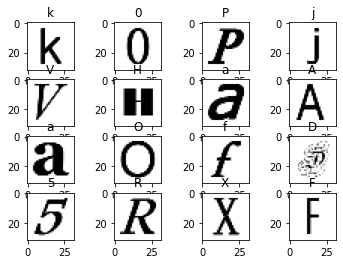

In [11]:
# Display 16 images
charDataIter = iter(dataLoader)
fig, ax = plt.subplots(4, 4)
for i in range(16):
    img, label = next(charDataIter)
    ax[i // 4, i % 4].imshow(img.squeeze().numpy(), cmap="gray")
    ax[i // 4, i % 4].set_title(classMap[label[0]])
plt.show()

# Utils

In [25]:
def GetAccuracy(model, testLoader, testSetSize):
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (imgs, labels) in enumerate(testLoader):
            # Break when reach test set size
            if i >= testSetSize:
                break

            # Reshape images to (batch_size, 1, 32, 32)
            imgs = imgs.view(-1, 1, 32, 32)
            labels = torch.tensor(labels)
            # Forward pass
            out = model(imgs)
            # Get the index of the max log-probability
            _, predicted = torch.max(out.data, 1)
            # Compute the number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Compute the accuracy
    accuracy = 100 * correct / total
    return accuracy

# Training

In [19]:
EPOCH = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.01

In [20]:
trainLoader = DataLoader(dataset=charDataSet, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(dataset=charDataSet, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
# Define the model
class CharClassifier(nn.Module):
    def __init__(self):
        super(CharClassifier, self).__init__()
        # Input size: (1, 32, 32)
        # Convolutional layer 1: (1, 32, 32) -> (16, 30, 30)
        self.conv1 = nn.Conv2d(1, 16, 3)
        # Pooling layer 1: (16, 30, 30) -> (16, 15, 15)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        # Convolutional layer 2: (16, 15, 15) -> (32, 13, 13)
        self.conv2 = nn.Conv2d(16, 32, 3)
        # Pooling layer 2: (32, 13, 13) -> (32, 6, 6)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        # Fully connected layer: (32*6*6) -> (256)
        self.fc1 = nn.Linear(32*6*6, 256)
        # Hidden layer: (256) -> (128)
        self.fc2 = nn.Linear(256, 128)
        # Output layer: (64) -> (size of classMap)
        self.fc3 = nn.Linear(128, len(classMap))

    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1, 32*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
# Init the model
model = CharClassifier()

# Define the loss function
lossFunc = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [28]:
stepNum = len(trainLoader)
for epoch in range(EPOCH):
    for i, (imgs, labels) in enumerate(trainLoader):
        # Reshape images to (batch_size, 1, 32, 32)
        imgs = imgs.view(-1, 1, 32, 32)
        labels = torch.tensor(labels)
        # Forward pass
        out = model(imgs)
        # Compute loss
        loss = lossFunc(out, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        if (i + 1) % (stepNum // 4) == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch + 1, EPOCH, i + 1, stepNum, loss.item()))
    # Get accuracy on test set
    accuracy = GetAccuracy(model, testLoader, testSetSize=256)
    print("Epoch [{}/{}], Test Accuracy: {:.2f}%".format(epoch + 1, EPOCH, accuracy))

/tmp/ipykernel_355067/513934584.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Epoch [1/10], Step [984/3937], Loss: 0.3450
Epoch [1/10], Step [1968/3937], Loss: 0.3775
Epoch [1/10], Step [2952/3937], Loss: 0.2392
Epoch [1/10], Step [3936/3937], Loss: 0.2403


/tmp/ipykernel_355067/3739188027.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Epoch [1/10], Test Accuracy: 87.16%


KeyboardInterrupt: 

# Accuracy

In [27]:
# Get the accuracy on the test set
accuracy = GetAccuracy(model, testLoader, testSetSize=1024)
print("Test set accuracy: {:.2f}%".format(accuracy))

/tmp/ipykernel_355067/3739188027.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Test set accuracy: 86.59%
